# 📊 Exploratory Data Analysis (EDA)

In [31]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

In [32]:
#Loading the data
DATA = Path("../data")
TRAIN_PATH = DATA / 'train.csv'
TEST_PATH = DATA / 'test.csv'

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH) #Only a preview of the real testing set

## Display dataset information

In [33]:
pd.set_option('display.max_colwidth', None)   # no truncation
print("=== TRAIN SET INFO ===")
print(train_df.info())
print("\n=== TEST SET INFO ===")
print(test_df.info())

=== TRAIN SET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB
None

=== TEST SET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   re

# Show random examples

In [34]:
train_example = train_df.sample(1, random_state=42)
test_example = test_df.sample(1, random_state=42)

print("=== 🧩 Example from Training Set ===")
display(train_example)

print("\n=== 🧩 Example from Test Set ===")
display(test_example)

# If the dataset has text columns, you can visualize them directly:
if "prompt" in train_df.columns and "response" in train_df.columns:
    print("\n--- Example Prompt ---")
    print(train_example["prompt"].values[0])
    print("\n--- Example Response ---")
    print(train_example["response"].values[0])

=== 🧩 Example from Training Set ===


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
37379,2785062085,gpt-3.5-turbo-0613,codellama-34b-instruct,"[""what does hello world mean""]","[""\""Hello, World!\"" is a phrase used in computer programming to introduce beginners to a new programming language. It is often the first program that a programmer writes when learning a new language. The program typically displays the words \""Hello, World!\"" on the screen or console. It serves as a basic starting point to verify that the programming environment is set up correctly and to demonstrate the basic syntax of the language.""]","[""\""Hello, World!\"" is a common phrase used to display a message on a computer screen. It is often used as a simple test to ensure that a computer program or system is working correctly. When a computer program is executed, it will typically print \""Hello, World!\"" to the screen, indicating that the program has been executed successfully.""]",1,0,0



=== 🧩 Example from Test Set ===


,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange yesterday. How many oranges do I have?""]","[""You have two oranges today.""]","[""You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today.""]"


# Label distribution in training data

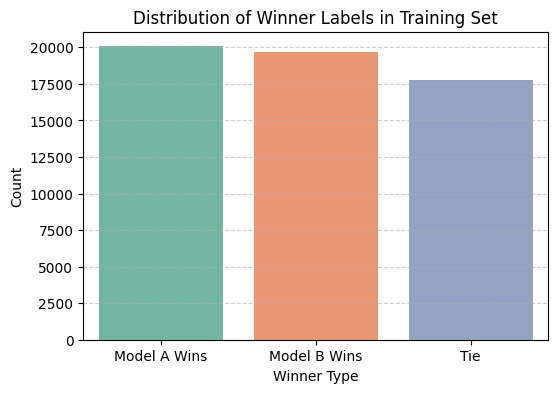

📊 Winner Label Proportions (%):

winner
Model A Wins    34.91
Model B Wins    34.19
Tie             30.90
Name: proportion, dtype: float64


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine binary outcome columns into a single label
train_df['winner'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1)

# Rename for readability
train_df['winner'] = train_df['winner'].replace({
    'winner_model_a': 'Model A Wins',
    'winner_model_b': 'Model B Wins',
    'winner_tie': 'Tie'
})

# Plot label distribution
plt.figure(figsize=(6, 4))
sns.countplot(
    x='winner',
    hue='winner',             # 🔧 connect hue to variable
    data=train_df,
    palette='Set2',
    legend=False              # 🔧 suppress legend
)
plt.title('Distribution of Winner Labels in Training Set')
plt.xlabel('Winner Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Print proportions
label_counts = train_df['winner'].value_counts(normalize=True).mul(100).round(2)
print("📊 Winner Label Proportions (%):\n")
print(label_counts)

# Studying the impact of the responses'length on the outcome

In [36]:
train_df['len_a'] = train_df['response_a'].astype(str).apply(len)
train_df['len_b'] = train_df['response_b'].astype(str).apply(len)

# Extract winners per row
def winner_model(row):
    if row['winner_model_a'] == 1:
        return row['model_a']
    elif row['winner_model_b'] == 1:
        return row['model_b']
    elif row['winner_tie'] == 1:
        return 'tie'
    else:
        return None

train_df['winner_name'] = train_df.apply(winner_model, axis=1)

# Collect data for each model’s A and B appearances
df_a = train_df[['model_a','len_a']].rename(columns={'model_a':'model','len_a':'length'})
df_b = train_df[['model_b','len_b']].rename(columns={'model_b':'model','len_b':'length'})
lengths = pd.concat([df_a, df_b])

# Count wins & appearances
wins = train_df['winner_name'].value_counts().rename('wins').to_frame()
appearances = pd.concat([train_df['model_a'], train_df['model_b']]).value_counts().rename('appearances').to_frame()

# Average response length per model
avg_len = lengths.groupby('model')['length'].mean().rename('avg_length').to_frame()

# Merge summary
model_stats = appearances.join(wins, how='left').join(avg_len)
model_stats['win_rate'] = (model_stats['wins'] / model_stats['appearances']).fillna(0)
model_stats = model_stats.sort_values('win_rate', ascending=False)
display(model_stats.head(10))

,appearances,wins,avg_length,win_rate
gpt-4-1106-preview,7387,4073,2199.513740,0.551374
gpt-3.5-turbo-0314,1302,711,796.688172,0.546083
gpt-4-0125-preview,1160,596,2520.208621,0.513793
gpt-4-0314,4122,1993,1351.776322,0.483503
claude-1,3978,1747,1489.826546,0.439165
gpt-4-0613,6165,2450,1246.164477,0.397405
claude-instant-1,4136,1642,1248.366779,0.397002
qwen1.5-72b-chat,551,215,1729.428312,0.390200
claude-2.0,2456,956,1195.950733,0.389251
llama-2-70b-chat,3428,1277,1839.846558,0.372520


In [37]:
from scipy.stats import pearsonr

# Calculating correlation between length and winrate
corr, pval = pearsonr(model_stats['avg_length'], model_stats['win_rate'])
print(f"Correlation = {corr:.3f}, p-value = {pval:.3g}")

Correlation = 0.499, p-value = 2.75e-05


#### The results of both the table and the correlation score show that length seems to play a role into user preference, even if a model with smaller responses like gpt-3.5-turbo is still among the preferred models. It will be an interesting feature to try for the first step of our modeling.

# Studying the relevance of some lexicality metrics (sentiment, readability, diversity)

In [38]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Elias\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [45]:
from textstat import flesch_reading_ease
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import re

# Sentiment analyzer (light version)
sia = SentimentIntensityAnalyzer()

def lexical_diversity(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    if len(tokens) == 0:
        return 0.0
    return len(set(tokens)) / len(tokens)

def readability(text):
    try:
        return flesch_reading_ease(text)
    except:
        return 0.0

def sentiment_score(text):
    # VADER returns a compound score ∈ [-1,1]
    return sia.polarity_scores(text)["compound"]

# Apply to both responses
for col in ['response_a', 'response_b']:
    print(f"Processing {col}...")
    train_df[f'{col}_readability'] = train_df[col].astype(str).apply(readability)
    train_df[f'{col}_diversity'] = train_df[col].astype(str).apply(lexical_diversity)
    train_df[f'{col}_sentiment'] = train_df[col].astype(str).apply(sentiment_score)


Processing response_a...
Processing response_b...


In [46]:
#Compute relative differences
train_df['read_diff'] = train_df['response_a_readability'] - train_df['response_b_readability']
train_df['div_diff']  = train_df['response_a_diversity'] - train_df['response_b_diversity']
train_df['sent_diff'] = train_df['response_a_sentiment'] - train_df['response_b_sentiment']


In [47]:
#Correlate with user preference
features = ['read_diff', 'div_diff', 'sent_diff']
for f in features:
    corr, p = pearsonr(train_df[f], train_df['winner_model_a'])
    print(f"{f}: corr = {corr:.3f}, p = {p:.2g}")

read_diff: corr = 0.002, p = 0.62
div_diff: corr = -0.115, p = 6.1e-168
sent_diff: corr = 0.032, p = 1.3e-14


# Studying the impact of more lexicality metrics (Paragraph count, List / bullet usage, Code block presence)

In [42]:
# Helper: count regex matches safely
def count_pattern(text, pattern):
    if not isinstance(text, str):
        return 0
    return len(re.findall(pattern, text))

# Paragraph breaks: "\n\n"
def paragraph_count(text):
    return text.count('\\n\\n')

# List / bullet usage: "-", "•", or numbered lists
def list_count(text):
    return count_pattern(text, r"(^\s*[\-\*•]\s|\d+\.)")

# Code block presence: "```" or code-like tokens
def code_count(text):
    return count_pattern(text, r"```|(\bdef\b|\bclass\b|;|\{|\})")

# Quote / markdown emphasis: ">", "**", or blockquotes
def quote_count(text):
    return count_pattern(text, r">|\*\*")

In [43]:
# Compute structural features for A and B responses
for col in ['response_a', 'response_b']:
    train_df[f'para_count_{col[-1]}'] = train_df[col].apply(paragraph_count)
    train_df[f'list_count_{col[-1]}'] = train_df[col].apply(list_count)
    train_df[f'code_count_{col[-1]}'] = train_df[col].apply(code_count)
    train_df[f'quote_count_{col[-1]}'] = train_df[col].apply(quote_count)

# Compute relative differences (A - B)
for feat in ['para_count', 'list_count', 'code_count', 'quote_count']:
    train_df[f'{feat}_diff'] = train_df[f'{feat}_a'] - train_df[f'{feat}_b']


In [44]:
# Correlation with Model A winning
print("=== 🧩 Correlation between structural features and preference ===")
for f in ['para_count_diff','list_count_diff','code_count_diff','quote_count_diff']:
    corr, p = pearsonr(train_df[f], train_df['winner_model_a'])
    print(f"{f:20s} corr = {corr:.3f}, p = {p:.2g}")

=== 🧩 Correlation between structural features and preference ===
para_count_diff      corr = 0.143, p = 2.2e-261
list_count_diff      corr = 0.072, p = 3.9e-66
code_count_diff      corr = 0.035, p = 1.2e-16
quote_count_diff     corr = 0.062, p = 6.6e-50


#### In the first step of our modeling, we can try to focus on paragraph, list and quote counts as features.